## Regression with Categorical Outcome Variable: NBA Data Set

In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
#Import Data
NBA = pd.read_csv("Assignment Data/NBA_Games2.csv")

In [4]:
NBA.head()

,CITY,TEAM_NAME,TEAM_ID,NICKNAME,STATE,YEAR_FOUNDED,SEASON_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,WIN
0,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900072,2019-07-12,...,13,23,36,14,15,3,12,24,8.0,1
1,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900060,2019-07-11,...,9,28,37,19,10,8,22,25,-5.0,0
2,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900042,2019-07-09,...,7,27,34,17,5,5,18,21,18.2,1
3,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900023,2019-07-07,...,9,27,36,7,7,10,18,28,-24.0,0
4,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900013,2019-07-06,...,9,30,39,13,11,6,13,21,2.0,0


In [5]:
NBA.loc[NBA["GAME_ID"] == 1521900072, ["MATCHUP"]]

,MATCHUP
0,ATL @ SAS
13440,SAS vs. ATL


In [6]:
NBA.columns

Index(['CITY', 'TEAM_NAME', 'TEAM_ID', 'NICKNAME', 'STATE', 'YEAR_FOUNDED',
       'SEASON_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PLUS_MINUS', 'WIN'],
      dtype='object')

In [7]:
NBA['TEAM_ID'] = NBA['TEAM_ID'].astype(int)
NBA['YEAR_FOUNDED'] = NBA['YEAR_FOUNDED'].astype(int)
NBA['SEASON_ID'] = NBA['SEASON_ID'].astype(int)
NBA['GAME_ID'] = NBA['GAME_ID'].astype(int)
pd.to_datetime(NBA['GAME_DATE'])
NBA[['MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
    'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
    'TOV', 'PF', 'WIN']] = NBA[['MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                                'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                                'TOV', 'PF', 'WIN']].astype(int)
NBA[['MIN', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS']] = NBA[['MIN', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS']].astype(float)

### Step 1. Building the Dataset – NBA Data set 

extract 2017 regular season records, named “NBA _2017”. The regular season games can be defined with a Season ID equal to 22017 and a Game ID less than 1000000000 (these filters will exclude preseason games).

In [8]:
NBA_2017 = NBA[ (NBA["SEASON_ID"] == 22017) & (NBA["GAME_ID"] <= 1000000000) ]

In [9]:
NBA_2017.drop(["CITY", "TEAM_ID", "NICKNAME", "STATE", "YEAR_FOUNDED", "SEASON_ID", "TEAM_ABBREVIATION"], axis=1, inplace=True)

In [10]:
NBA_2017.describe

<bound method NDFrame.describe of                TEAM_NAME   GAME_ID   GAME_DATE      MATCHUP WL    MIN  PTS  \
101        Atlanta Hawks  21701214  2018-04-10  ATL vs. PHI  L  240.0  113   
102        Atlanta Hawks  21701202  2018-04-08    ATL @ BOS  W  239.0  112   
103        Atlanta Hawks  21701184  2018-04-06    ATL @ WAS  W  239.0  103   
104        Atlanta Hawks  21701172  2018-04-04  ATL vs. MIA  L  239.0   86   
105        Atlanta Hawks  21701158  2018-04-03    ATL @ MIA  L  240.0   98   
...                  ...       ...         ...          ... ..    ...  ...   
18106  Charlotte Hornets  21700070  2017-10-27  CHA vs. HOU  L  242.0   93   
18107  Charlotte Hornets  21700055  2017-10-25  CHA vs. DEN  W  240.0  110   
18108  Charlotte Hornets  21700044  2017-10-23    CHA @ MIL  L  240.0   94   
18109  Charlotte Hornets  21700017  2017-10-20  CHA vs. ATL  W  240.0  109   
18110  Charlotte Hornets  21700003  2017-10-18    CHA @ DET  L  238.0   90   

       FGM  FGA  FG_PCT  ... 

Manipulate the dataset and define the variables. This proceeds in several steps:

Filter 2017 regular season records and select columns to be used for analysis.

Manipulate the MATCHUP column to obtain columns for each team.

Create the home dummy variable

In [11]:
NBA_2017['HOME'] = NBA_2017['MATCHUP'].apply(lambda x: 1 if "vs." in x else 0)

In [12]:
home_teams = NBA_2017[NBA_2017['HOME'] == 1].copy()
away_teams = NBA_2017[NBA_2017['HOME'] == 0].copy()

home_teams.rename(columns=lambda x: 'home_' + x, inplace=True)
away_teams.rename(columns=lambda x: 'away_' + x, inplace=True)

home_teams.rename(columns={'home_GAME_ID': 'GAME_ID'}, inplace=True)
away_teams.rename(columns={'away_GAME_ID': 'GAME_ID'}, inplace=True)

NBA_2017_combined = pd.merge(home_teams, away_teams, on='GAME_ID')

In [13]:
NBA_2017_combined.head()

,home_TEAM_NAME,GAME_ID,home_GAME_DATE,home_MATCHUP,home_WL,home_MIN,home_PTS,home_FGM,home_FGA,home_FG_PCT,...,away_DREB,away_REB,away_AST,away_STL,away_BLK,away_TOV,away_PF,away_PLUS_MINUS,away_WIN,away_HOME
0,Atlanta Hawks,21701214,2018-04-10,ATL vs. PHI,L,240.0,113,41,98,0.0,...,43,54,29,7,8,18,22,8.0,1,0
1,Atlanta Hawks,21701172,2018-04-04,ATL vs. MIA,L,239.0,86,33,90,0.0,...,44,54,23,9,10,11,17,29.0,1,0
2,Atlanta Hawks,21701147,2018-04-01,ATL vs. ORL,W,241.0,94,41,85,0.0,...,30,41,19,8,6,5,10,-6.0,0,0
3,Atlanta Hawks,21701130,2018-03-30,ATL vs. PHI,L,239.0,91,36,101,0.0,...,44,53,34,10,6,15,18,10.0,1,0
4,Atlanta Hawks,21701021,2018-03-15,ATL vs. CHA,L,242.0,117,42,90,0.0,...,39,45,30,3,3,10,21,12.0,1,0


#### Step 2. Running Regression – Part I

Fit LPM of win (W vs. L) on Pythagorean Winning Percentage.

In [18]:
home_wins = NBA_2017_combined.groupby("home_TEAM_NAME", as_index=False)["home_WIN"].sum().rename(columns={'home_TEAM_NAME': 'TEAM_NAME'})
away_wins = NBA_2017_combined.groupby("away_TEAM_NAME", as_index=False)["away_WIN"].sum().rename(columns={'away_TEAM_NAME': 'TEAM_NAME'})
home_games = NBA_2017_combined.groupby("home_TEAM_NAME", as_index=False)["GAME_ID"].count().rename(columns={'GAME_ID': 'home_GAMES', 'home_TEAM_NAME': 'TEAM_NAME'})
away_games = NBA_2017_combined.groupby("away_TEAM_NAME", as_index=False)["GAME_ID"].count().rename(columns={'GAME_ID': 'away_GAMES', 'away_TEAM_NAME': 'TEAM_NAME'})

total_wins = pd.merge(home_wins, away_wins, on="TEAM_NAME")
total_games = pd.merge(home_games, away_games, on="TEAM_NAME")

total_wins['Total_WIN'] = total_wins['home_WIN'] + total_wins['away_WIN']
total_games['Total_GAMES'] = total_games['home_GAMES'] + total_games['away_GAMES']
total_games_wl = pd.merge(total_wins, total_games, on="TEAM_NAME")

total_games_wl['wpct'] = total_games_wl['Total_WIN']/total_games_wl['Total_GAMES']

In [19]:
home_pts = NBA_2017_combined.groupby("home_TEAM_NAME", as_index=False)["home_PTS"].sum().rename(columns={'home_PTS': 'PTS_home', 'home_TEAM_NAME': 'TEAM_NAME'})
away_pts = NBA_2017_combined.groupby("away_TEAM_NAME", as_index=False)["away_PTS"].sum().rename(columns={'away_PTS': 'PTS_away', 'away_TEAM_NAME': 'TEAM_NAME'})
home_pts_allowed = NBA_2017_combined.groupby("home_TEAM_NAME", as_index=False)["away_PTS"].sum().rename(columns={'away_PTS': 'PTS_allowed_home', 'home_TEAM_NAME': 'TEAM_NAME'})
away_pts_allowed = NBA_2017_combined.groupby("away_TEAM_NAME", as_index=False)["home_PTS"].sum().rename(columns={'home_PTS': 'PTS_allowed_away', 'away_TEAM_NAME': 'TEAM_NAME'})

total_pts = pd.merge(home_pts, away_pts, on="TEAM_NAME")
total_pts_allowed = pd.merge(home_pts_allowed, away_pts_allowed, on="TEAM_NAME")

total_pts['Total_PTS'] = total_pts['PTS_home'] + total_pts['PTS_away']
total_pts_allowed['Total_PTS_allowed'] = total_pts_allowed['PTS_allowed_home'] + total_pts_allowed['PTS_allowed_away']
total_pts = pd.merge(total_pts, total_pts_allowed, on="TEAM_NAME")

total_pts["pyth_wpct"] = total_pts["Total_PTS"]**2 / (total_pts["Total_PTS"]**2 + total_pts["Total_PTS_allowed"]**2)

In [21]:
total_stats = pd.merge(total_games_wl[["TEAM_NAME", "wpct"]], total_pts[["TEAM_NAME", "pyth_wpct"]], on="TEAM_NAME")
total_stats

,TEAM_NAME,wpct,pyth_wpct
0,Atlanta Hawks,0.300000,0.474490
1,Boston Celtics,0.675000,0.517969
2,Brooklyn Nets,0.350000,0.483214
3,Charlotte Hornets,0.437500,0.500808
4,Chicago Bulls,0.337500,0.467080
5,Cleveland Cavaliers,0.612500,0.504871
6,Dallas Mavericks,0.291139,0.484715
7,Denver Nuggets,0.569620,0.506331
8,Detroit Pistons,0.475000,0.499579
9,Golden State Warriors,0.705128,0.526693


In [24]:
total_stats["home_TEAM_NAME"] = total_stats["TEAM_NAME"]
NBA_2017_combined = pd.merge(NBA_2017_combined, total_stats , on='home_TEAM_NAME')

In [26]:
NBA_2017_combined_lm = smf.ols(formula = "wpct ~ pyth_wpct", data = NBA_2017_combined).fit()
NBA_2017_combined_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wpct   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 1.194e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        04:48:57   Log-Likelihood:                 1964.9
No. Observations:                1148   AIC:                            -3926.
Df Residuals:                    1146   BIC:                            -3916.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9016      0.031    -93.141      0.000      -2.963      -2.840
pyth_wpct      6.8042      0.062    109.281      0.000       6.682       6.926
==============================================================================
Omnibus:                       24.892   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.820
Skew:                          -0.171   Prob(JB):                     0.000223
Kurtosis:                       2.515   Cond. No.                         60.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot the LPM 

Text(0.5, 1.0, 'Correlation: wpct vs pyth_wpct')

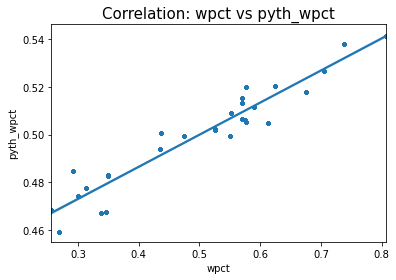

In [27]:
sns.regplot(x = "wpct", y = "pyth_wpct", data = NBA_2017_combined ,  marker=".")
plt.xlabel("wpct")
plt.ylabel("pyth_wpct")
plt.title("Correlation: wpct vs pyth_wpct", fontsize=15)

Fit a logistic regression on win on Pythagorean Winning Percentage.

In [28]:
NBA_2017_combined_logit = smf.glm(formula = "wpct ~ pyth_wpct", data = NBA_2017_combined, family = sm.families.Binomial()).fit()
NBA_2017_combined_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wpct   No. Observations:                 1148
Model:                            GLM   Df Residuals:                     1146
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -494.72
Date:                Sun, 17 Mar 2024   Deviance:                       9.0501
Time:                        04:49:17   Pearson chi2:                     9.03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.5647      1.578     -9.230      0.000     -17.657     -11.472
pyth_wpct     29.1290      3.153      9.240      0.000      22.950      35.308
==============================================================================
"""

Print the results including coefficients, p-values, and dependent variable

In [29]:
print("Coefficients")
print(NBA_2017_combined_logit.params)
print("p-Values")
print(NBA_2017_combined_logit.pvalues)
print("Dependent variables")
print(NBA_2017_combined_logit.model.endog_names)

Coefficients
Intercept   -14.56473
pyth_wpct    29.12896
dtype: float64
p-Values
Intercept    2.704392e-20
pyth_wpct    2.466496e-20
dtype: float64
Dependent variables
wpct


Obtain the fitted results using the logistic regression model

In [31]:
# fit the model to calculate probabilities of winning on each game
estimated_wpct = NBA_2017_combined_logit.predict()
estimated_wpct

array([0.32227936, 0.32227936, 0.32227936, ..., 0.50581868, 0.50581868,
       0.50581868])

In [32]:
fittedWin = [1 if x > .5 else 0 for x in estimated_wpct]
fittedWin[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Calculate the success rate

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(NBA_2017_combined["home_WIN"], fittedWin)

array([[270, 209],
       [206, 463]])

In [35]:
Success_Rate = round( (270+463)/(270+463+209+206)*100, 2)
print( "Success Rate: " + str( Success_Rate ) + "%" )

Success Rate: 63.85%


Fit multiple logistic regression by incorporating the home team advantage.

In [42]:
NBA_2017_HOME_logit = smf.glm(formula = "wpct ~ pyth_wpct + home_HOME", data = NBA_2017_combined, family = sm.families.Binomial()).fit()
NBA_2017_HOME_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wpct   No. Observations:                 1148
Model:                            GLM   Df Residuals:                     1146
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -494.72
Date:                Sun, 17 Mar 2024   Deviance:                       9.0501
Time:                        04:55:10   Pearson chi2:                     9.03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.2824      0.789     -9.230      0.000      -8.829      -5.736
pyth_wpct     29.1290      3.152      9.240      0.000      22.950      35.308
home_HOME     -7.2824      0.789     -9.230      0.000      -8.829      -5.736
==============================================================================
"""

Obtain the fitted results using the logistic regression model

In [43]:
estimated_Wpct_2 = NBA_2017_HOME_logit.predict()
fittedWin_2 = [1 if x > .5 else 0 for x in estimated_Wpct_2]
fittedWin_2[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Obtain the success rate.

In [44]:
confusion_matrix(NBA_2017_combined["home_WIN"], fittedWin_2)

array([[270, 209],
       [206, 463]])

In [45]:
Success_Rate_2 = round( (270+463)/(270+463+209+206)*100, 2)
print( "Success Rate: " + str( Success_Rate_2 ) + "%" )

Success Rate: 63.85%
